### Description:

- Clean variables from flowsheet, finalized with vital signs and GCS scores only
- GCS and some other variables are ultimately not used due to inaccuracy and too many (or ALL) missing values.

Inputs: 
- `flowsheet.csv` (from SQL)
- `2_2_coh2_heightweight.csv` -- cohort which has demographics, ESI, and imputed HW processed


Output files: 

- `2_3_coh2_vs1st` -- to update cohort after drop na
- `1_3_cohort` -- cohort with a complete set of vital signs, for ESI imputation
- `2_3_coh3_vitals_stats` -- summary stats of vital signs


### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
# library(mice)

options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




### Set up and run queries
Do this on Nero GCP as querying from a local computer takes much longer time

In [7]:
# CREDENTIALS depending on LOCATIONS:
# credential <- paste0("/home/", "minh084", "/.config/gcloud/application_default_credentials.json")

# local computer
# credential <- "C:/Users/User/AppData/Roaming/gcloud/application_default_credentials.json"

# Nero onprem
# credential <- "/home/minh084/.config/gcloud/application_default_credentials.json"

# Nero gcp notebook
credential <- "/home/jupyter/.config/gcloud/application_default_credentials.json"

project_id <- "som-nero-phi-jonc101"

Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = credential)
Sys.setenv(GCLOUD_PROJECT = project_id)
gargle::credentials_app_default()

NULL

In [3]:
library(DBI)
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "shc_core" #, billing = project_id
)
con 
dbListTables(con)

<BigQueryConnection>
  Dataset: som-nero-phi-jonc101.shc_core
  Billing: som-nero-phi-jonc101

[1] "adt"                 "allergy"             "culture_sensitivity"
 [4] "demographic"         "dep_map"             "diagnosis_code"     
 [7] "drg_code"            "encounter"           "family_hx"          
[10] "flowsheet"           "lab_result"          "lda"                
[13] "mapped_meds"         "mar"                 "med_orderset"       
[16] "ndc_code"            "order_med"           "order_proc"         
[19] "order_quest"         "proc_note"           "proc_orderset"      
[22] "procedure_code"      "prov_map"            "social_hx"          
[25] "treatment_team"

### Check other flowsheet variables, mainly vital signs:
   * Combine/collapse similar names into standard names for the below features
   * Look at how common these are, look at the distributions, check extreme values on either sides
   * Investigate some of these to see how far they are off from normal range to be considered errorneous.
   * Note: num_value1 vs. num_value2, see details below
   * Replace erroneous values as "NA".
   
**1. Blood pressure**: 
* DBP: num_value2 --> return NA if SBP > 10*DBP 
* There's no DBP without an SBP
* Return NA for BP if both DBP and SBP are 0
* SBP: return NA if < 30 or 33, same effect

**2. Pulse**: return NA if < 21

**3. Temp**: exist in both num_value1 and num_value2
* num_value2 is not NA only when there's num_value1. if num_value1 is NA then num_value2 is also NA
* For num_value1 <= 60, take it as Celcius degree
* For num_value1 > 60, convert this temp in F to C
* Return NA for num_value1 < 20 --> only 2: 0.1 and 9.4 (lowest 26C)

**4. Respiratory Rate (RR)**: return NA for < 4 or > 60

**5. SpO2**: return NA for < 40%. although there are lots of these, they are difficult to interpret without knowing O2 (LPM) and delivery device, which are not a lot here. missing can be considered as room air.

**6. GCS**: points are different from scores, only use scores
* num_value2 are the normal GCS score, num_value1 can be just points on 0-4 scale

In [2]:
# read inputs
datadir = "../../DataTD"
featuredir = "../../OutputTD/2_features"


cohort <- read.csv(file.path(featuredir, "2_2_coh2_heightweight.csv"))
vitals0 <- read.csv(file.path(datadir, "flowsheet.csv")) 

# check for unique CSNs and MRNs
nrow(cohort) #45796
nrow(vitals0) #depending on which cohort_demo used to query flowsheet 218930
colnames(vitals0) #854342

[1] 45796

[1] 929494

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "hosp_admsn_time"         "ed_time_hr"             
 [9] "gender"                  "race"                   
[11] "language"                "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "recent_date"             "age"                    
[17] "template"                "row_disp_name"          
[19] "units"                   "recorded_time_utc"      
[21] "num_value1"              "num_value2"

In [3]:
head(cohort, n=1)
head(vitals0, n=1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81


,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,template,row_disp_name,units,recorded_time_utc,num_value1,num_value2
,<chr>,<dbl>,<int>,<chr>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,JCd2d5e8,131238583282,0,2017-08-23 08:29:00+00:00,26143772,3,2017-08-23 05:47:00+00:00,2.7,Female,Asian,English,152.4,52.16,MEDICAID,2019-01-01,52,Psych Assessment,Activity,,2017-08-23 06:20:00+00:00,NA,NA


In [4]:
vitals0 %>% group_by(units) %>% count()
vitals0 %>% group_by(row_disp_name) %>% count() %>% arrange(-n)

units,n
<chr>,<int>
,895345
bpm,12
LPM,34137


row_disp_name,n
<chr>,<int>
Pulse,227570
Resp,216017
BP,213405
Temp,82081
Temp (in Celsius),63143
Heart Rate,60926
O2 (LPM),34137
Mobility,16097
Activity,8326


In [5]:
# should only keep "Resp Rate"
vitals0 %>% filter(row_disp_name %in% c("Resp Rate", "Resting Pulse Rate: (Record BPM)", "Temperature")) %>%
            arrange(row_disp_name) %>% select(template, row_disp_name, num_value1, num_value2)
# vitals0 %>% filter(row_disp_name %in% c("Blood Pressure", "Arterial Systolic BP" , "NIBP")) %>%
#             arrange(row_disp_name) %>% select(template, row_disp_name, units, num_value1, num_value2)

template,row_disp_name,units,num_value1,num_value2
<chr>,<chr>,<chr>,<dbl>,<dbl>
DATA VALIDATE,Resp Rate,bpm,27,NA
DATA VALIDATE,Resp Rate,bpm,26,NA
DATA VALIDATE,Resp Rate,bpm,20,NA
DATA VALIDATE,Resp Rate,bpm,8,NA
DATA VALIDATE,Resp Rate,bpm,6,NA
DATA VALIDATE,Resp Rate,bpm,29,NA
VS,Resp Rate,bpm,19,NA
DATA VALIDATE,Resp Rate,bpm,28,NA
DATA VALIDATE,Resp Rate,bpm,10,NA


#### First, check the original vitals data to see which variables can be kept
Meaningful values:

Pulse, Resp, BP, Temp, Temp (in Celsius), Heart Rate, Resp Rate, NIBP

Already eliminated GCS from previous work in Triage project due to large missing data

In [6]:
# check summary to see num_value1 vs num_value
display_summary_num1and2 <- function(df, var1, var2){
    suppressWarnings(
        df %>% summarise(n=n(), 
                        mean1 = mean({{var1}}, na.rm=T), mean2 = mean({{var2}}, na.rm=T),
                        median1 = median({{var1}}, na.rm=T), median2 = median({{var2}}, na.rm=T),
                        min1 = min({{var1}}, na.rm=T), min2 = min({{var2}}, na.rm=T), 
                        max1 = max({{var1}}, na.rm=T), max2 = max({{var2}}, na.rm=T)) %>%
                arrange(desc(n))
    )
}

In [7]:
vitals0 %>% group_by(row_disp_name) %>% display_summary_num1and2(num_value1, num_value2)# %>% arrange(desc(n))

`summarise()` ungrouping output (override with `.groups` argument)



row_disp_name,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pulse,227570,88.718216,NaN,87.0,NA,0.0,Inf,300.0,-Inf
Resp,216017,19.238866,NaN,18.0,NA,0.0,Inf,189.0,-Inf
BP,213405,129.045829,75.78745,127.0,75.0,0.0,0.0,419.0,238.0
Temp,82081,98.286312,98.32806,98.2,98.3,0.1,96.7,110.2,102.9
Temp (in Celsius),63143,36.964841,NaN,36.8,NA,-17.7,Inf,43.4,-Inf
Heart Rate,60926,90.556001,NaN,89.0,NA,0.0,Inf,295.0,-Inf
O2 (LPM),34137,NaN,NaN,NA,NA,Inf,Inf,-Inf,-Inf
Mobility,16097,NaN,NaN,NA,NA,Inf,Inf,-Inf,-Inf
Activity,8326,NaN,NaN,NA,NA,Inf,Inf,-Inf,-Inf


In [8]:
# keep only some variables
vitals0 <- vitals0 %>% filter(row_disp_name %in% c('Pulse', 'Resp', 'BP', 'Temp', 'Temp (in Celsius)', 
                                                  ' Heart Rate', 'Resp Rate', 'NIBP'))
vitals0 %>% group_by(row_disp_name) %>% display_summary_num1and2(num_value1, num_value2)# %>% arrange(desc(n))

`summarise()` ungrouping output (override with `.groups` argument)



row_disp_name,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pulse,227570,88.71822,NaN,87.0,NA,0.0,Inf,300.0,-Inf
Resp,216017,19.23887,NaN,18.0,NA,0.0,Inf,189.0,-Inf
BP,213405,129.04583,75.78745,127.0,75.0,0.0,0.0,419.0,238.0
Temp,82081,98.28631,98.32806,98.2,98.3,0.1,96.7,110.2,102.9
Temp (in Celsius),63143,36.96484,NaN,36.8,NA,-17.7,Inf,43.4,-Inf
Resp Rate,11,18.18182,NaN,20.0,NA,2.0,Inf,29.0,-Inf
NIBP,1,140.00000,58.00000,140.0,58.0,140.0,58.0,140.0,58.0


In [9]:
colnames(vitals0)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "hosp_admsn_time"         "ed_time_hr"             
 [9] "gender"                  "race"                   
[11] "language"                "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "recent_date"             "age"                    
[17] "template"                "row_disp_name"          
[19] "units"                   "recorded_time_utc"      
[21] "num_value1"              "num_value2"

In [80]:
# combine cohort with vitals sign
vitals <- vitals0 %>% 
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                       template, row_disp_name, units, recorded_time_utc, num_value1, num_value2) %>%
                rename(recorded_time = recorded_time_utc) %>%
                filter(row_disp_name %in% c('Pulse', 'Resp', 'BP', 'Temp', 'Temp (in Celsius)', 
                                            'Heart Rate', 'Resp Rate', 'NIBP'))

# calculate difftime takes a while
# cohort_vitals <- left_join(cohort, vitals0) %>% 
#             mutate(timediff = as.numeric(difftime(admit_time, recorded_time, units = "mins"))) %>%
#             distinct()
# #             filter(ymd_hms(recorded_time) < ymd_hms(admit_time)) %>% # no need this one, SQL took care of this

# nrow(cohort_vitals) 
# summary(cohort_vitals$timediff) # all positive --> recorded time is before admit time

In [81]:
head(vitals, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,row_disp_name,units,recorded_time,num_value1,num_value2
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,JCe15c20,131254814765,31338316,Vitals,Resp,,2018-08-22 16:00:00+00:00,16,NA


### First observations:
- BP: num_value1 is SBP and num_value2 is DBP
- Temp: nothing between 45 - 75
    - for num_value1 > 75, it is in F
    - for num_value1 < 45, it is in C
        - there is one erroneous value < 10
        - these num_value1 tend to have a num_value 2 that is in F or NA in num_value2
- Temp in Celsius: cut off at < 26 as errors

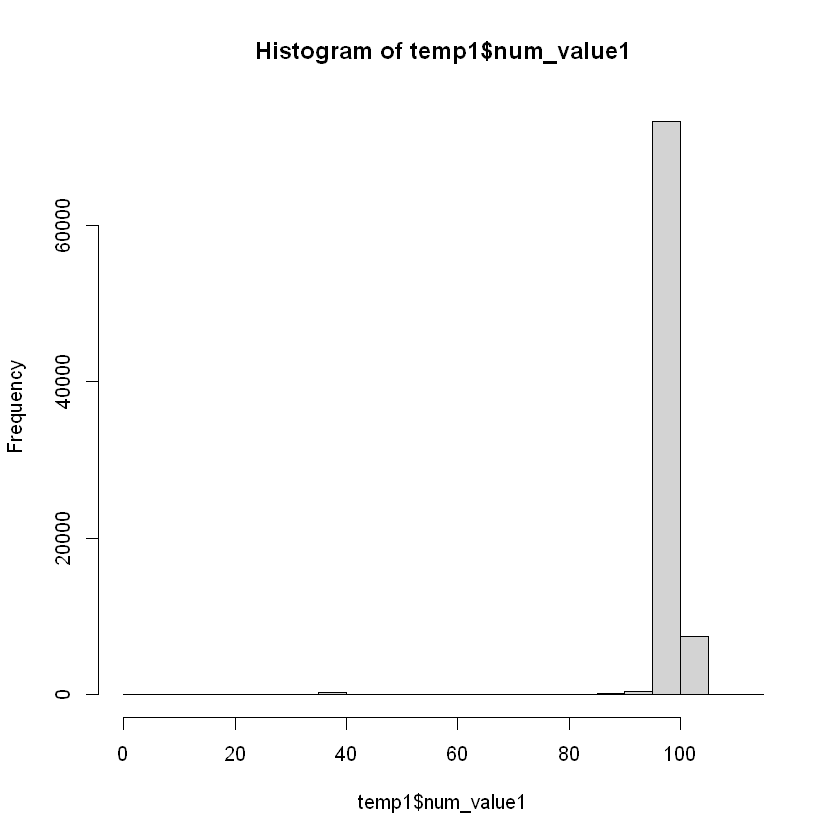

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  96.70   97.90   98.30   98.33   98.60  102.90   81803 

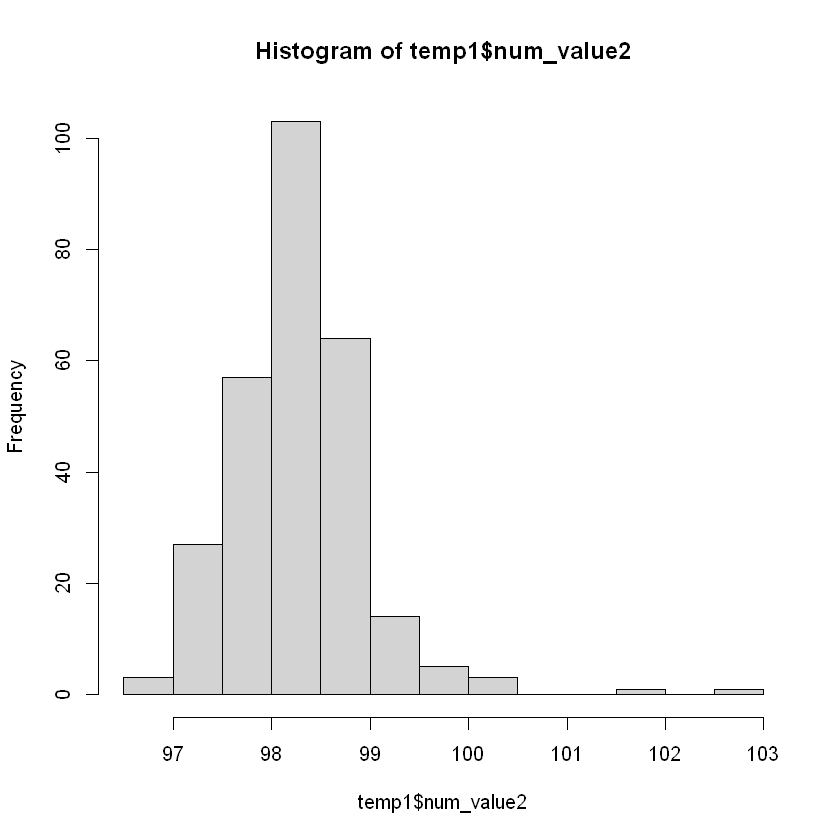

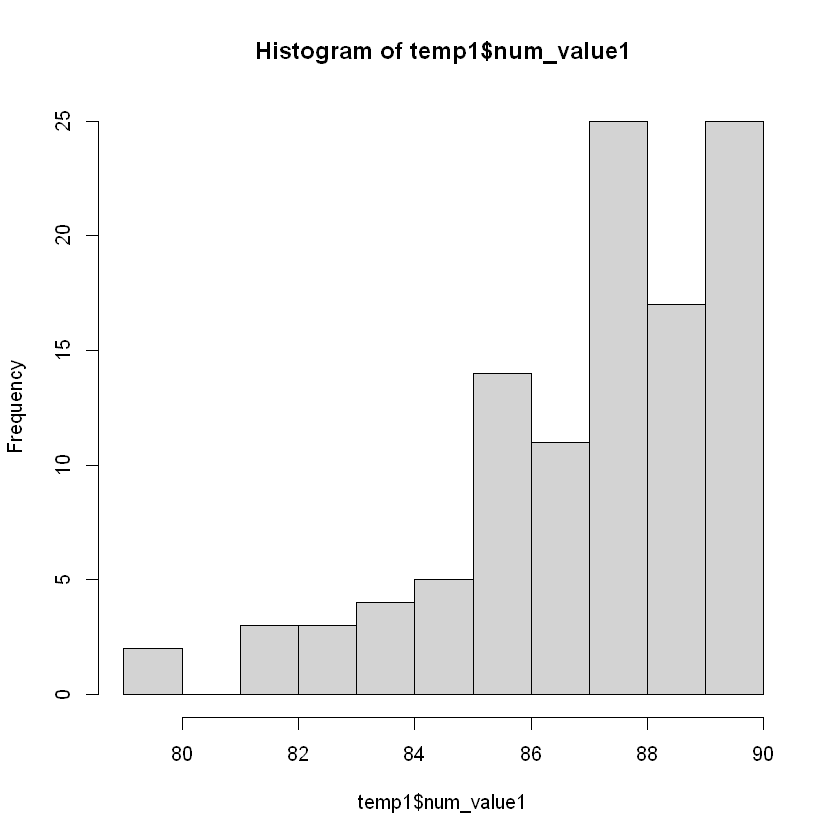

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.10   36.60   36.80   36.71   37.10   39.40 

,num_value1,num_value2
,<dbl>,<dbl>
1,0.1,NA
2,9.4,NA
3,35.9,96.7
4,36.0,96.8
5,36.1,97.0
6,36.2,97.2


[1] 0

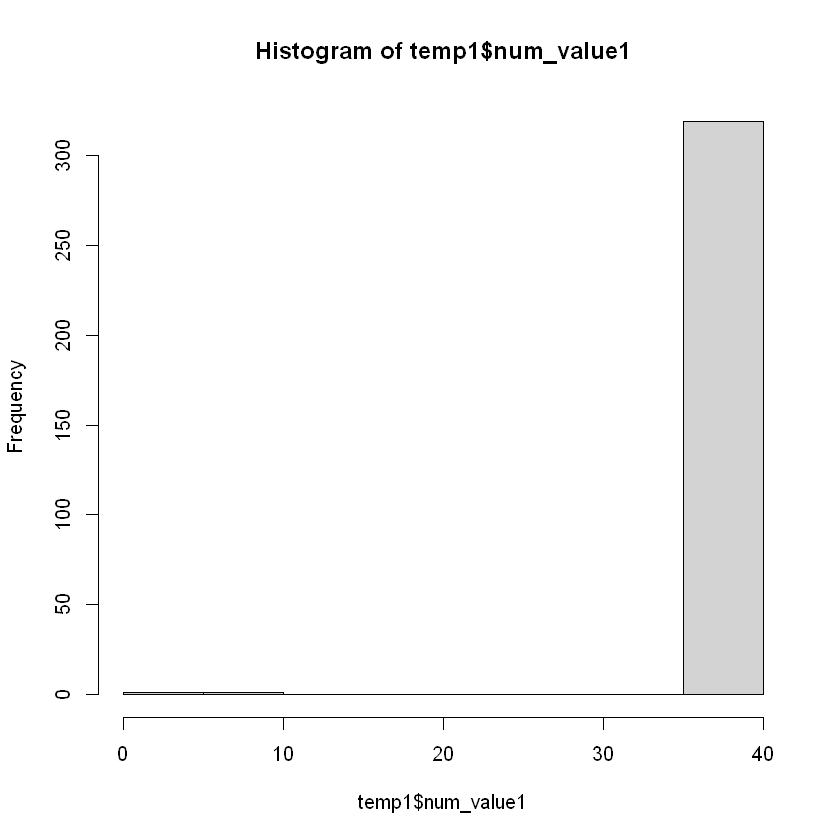

In [51]:
temp1 <- vitals %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2)
hist(temp1$num_value1)
hist(temp1$num_value2)
summary(temp1$num_value2)

temp1 <- vitals %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2) %>% filter(num_value1 < 90, num_value1 > 45)
hist(temp1$num_value1)

temp1 <- vitals %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2) %>% filter(num_value1 < 70) %>%
            arrange(num_value1)
hist(temp1$num_value1)
summary(temp1$num_value1)

head(temp1)

nrow(vitals %>% filter(row_disp_name == "Temp") %>% select(num_value1, num_value2) %>% filter(num_value1 < 75, num_value1 > 45))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   36.60   36.80   36.96   37.20   43.40     252 

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,row_disp_name,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
JCe2576f,131242579787,27727837,Custom Formula Data,Temp (in Celsius),,2017-12-20 01:00:00+00:00,-17.7,NA
JCe32127,131273852266,40114341,Custom Formula Data,Temp (in Celsius),,2019-07-22 21:27:00+00:00,-12.6,NA
JCd97240,131175721019,18240916,Custom Formula Data,Temp (in Celsius),,2016-01-12 02:12:00+00:00,2.4,NA
JCeafa07,131115241228,16644440,Custom Formula Data,Temp (in Celsius),,2015-10-05 15:00:00+00:00,2.4,NA
JCd7deec,131266090665,35800683,Custom Formula Data,Temp (in Celsius),,2019-03-25 18:21:00+00:00,2.4,NA
JCe6e228,131184920938,19575165,Custom Formula Data,Temp (in Celsius),,2016-05-22 02:00:00+00:00,2.4,NA
JCe33d66,131154123054,17662687,Custom Formula Data,Temp (in Celsius),,2015-11-14 08:55:00+00:00,2.5,NA
JCdf832c,131189332121,20225551,Custom Formula Data,Temp (in Celsius),,2016-05-23 23:30:00+00:00,2.5,NA
JCe5647e,131122461685,16858543,Custom Formula Data,Temp (in Celsius),,2015-09-24 19:15:00+00:00,2.6,NA


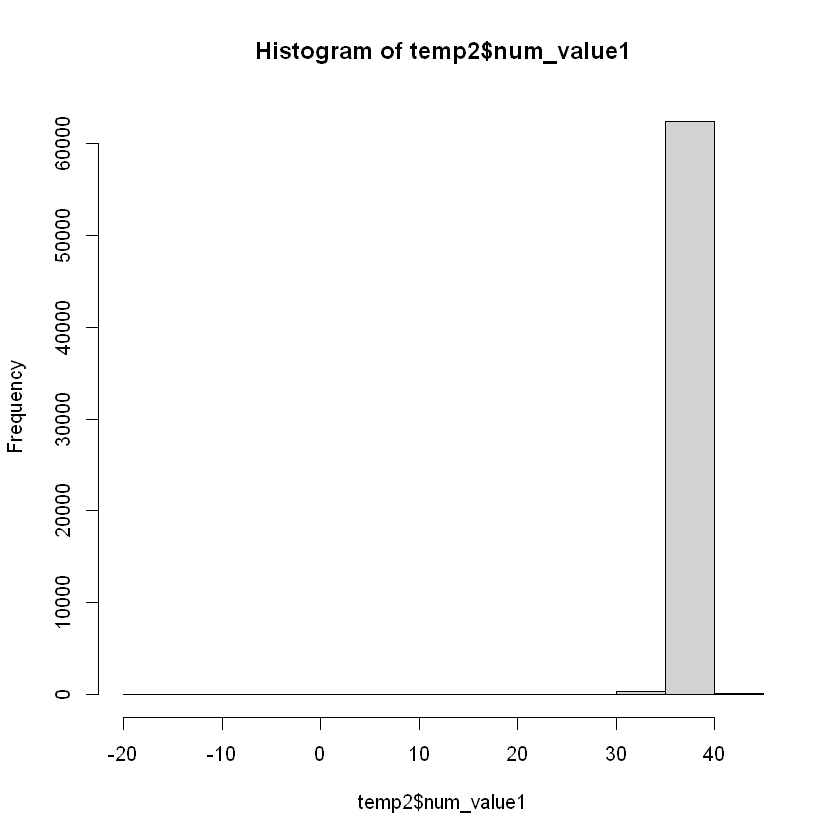

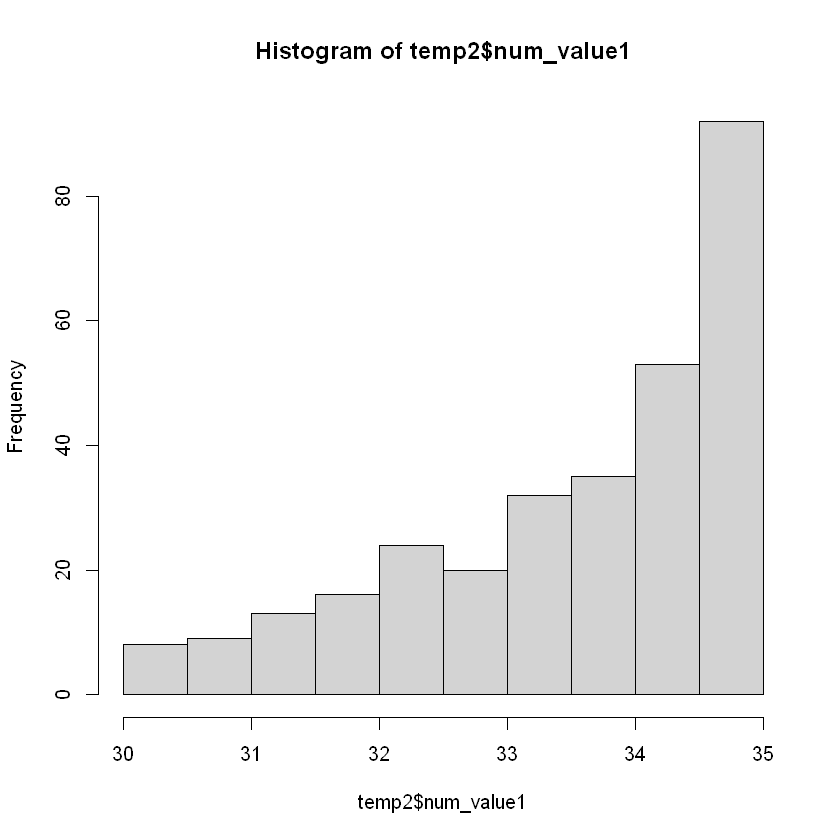

In [54]:
temp2 <- vitals %>% filter(row_disp_name == "Temp (in Celsius)")
hist(temp2$num_value1)
summary(temp2$num_value1)

temp2 <- vitals %>% filter(row_disp_name == "Temp (in Celsius)", num_value1 < 30)
temp2 %>% arrange(num_value1)

temp2 <- vitals %>% filter(row_disp_name == "Temp (in Celsius)", num_value1 < 35, num_value1 >=30)
hist(temp2$num_value1)

In [82]:
# rename the variables, combine similar ones
# only 1 name: SpO2 and BP # ifelse(str_detect(features, paste(GCS, collapse="|")), "GCS",
Pulse = c("Pulse", "Heart Rate") 
RR = c("Resp", "Resp Rate") # not using Respiratory Rate, different scale

# will name BP as SBP and take num_value1 only, DBP will be processed separately
# distinct will reduce many rows, that have values with same recorded time
vitals <- vitals %>% rename(features = row_disp_name) %>% 
                mutate(features = ifelse(features == "BP", "SBP",
                                         ifelse(features %in% Pulse, "Pulse", 
                                                ifelse(str_detect(features, "Temp"), "Temp", 
                                                       ifelse(features %in% RR, "RR", as.character(features)))))) %>% # last ... in ifelse(cond, iftrue, ...)
                distinct()
nrow(vitals)       
unique(vitals$features)
fs_feats <- c("Pulse", "RR", "SBP", "Temp")
vitals %>% filter(features %in% fs_feats) %>% group_by(features) %>% display_summary_num1and2(num_value1, num_value2)

[1] 802224

[1] "RR"    "SBP"   "Temp"  "Pulse" "NIBP"

`summarise()` ungrouping output (override with `.groups` argument)



features,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pulse,227569,88.71822,NaN,87.0,NA,0.0,Inf,300.0,-Inf
RR,216027,19.23883,NaN,18.0,NA,0.0,Inf,189.0,-Inf
SBP,213404,129.04583,75.78745,127.0,75.0,0.0,0.0,419.0,238.0
Temp,145223,71.59947,98.32806,97.5,98.3,-17.7,96.7,110.2,102.9


### Clean Temp:
- temp in Celsius is above 25 and below 45
- anything < 25 is even less than 10 and considered to be erroneous
- anything > 75 is considered in F 
- num_value2 is only F while num_value1 can be either F or C
- HOWEVER, if num_value1 is NA or num_value1 < 26, there is no num_value2! **So we can just use num_value1 for temp!**

In [105]:
summary(vitals %>% filter(features=="Temp") %>% select(num_value1, num_value2))
nrow(vitals %>% filter(features=="Temp", is.na(num_value1), !is.na(num_value2)))
nrow(vitals %>% filter(features=="Temp", num_value1 <= 25))

   num_value1      num_value2    
 Min.   :-17.7   Min.   : 96.70  
 1st Qu.: 36.9   1st Qu.: 97.90  
 Median : 97.5   Median : 98.30  
 Mean   : 71.6   Mean   : 98.33  
 3rd Qu.: 98.4   3rd Qu.: 98.60  
 Max.   :110.2   Max.   :102.90  
 NA's   :711     NA's   :144945  

[1] 0

[1] 32

### Check DBP and process this separately, to bind rows afterward

In [56]:
# check DBP (num_value2). Note: BP always have 2 values
nrow(vitals %>% filter(features == "SBP" & is.na(num_value1) & !is.na(num_value2)))
nrow(vitals %>% filter(features == "SBP" & is.na(num_value2) & !is.na(num_value1)))

# display some extrem values of DBP
options(repr.matrix.max.rows=150, repr.matrix.max.cols=20)
vitals %>% filter(features == 'SBP' & (num_value2 > 200 | num_value2 < 25)) %>% arrange(num_value2)

[1] 0

[1] 0

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
JCd04de5,131068992117,14201240,Vitals,SBP,,2015-03-01 01:18:00+00:00,60,0
JCd04de5,131068992117,14201240,Vitals,SBP,,2015-03-01 01:42:00+00:00,74,0
JC2a1a193,131274427714,40485010,Hemodynamic Measurements,SBP,,2019-08-24 20:31:04+00:00,0,0
JCd4aff3,131268077771,37106042,Vitals,SBP,,2019-05-10 16:30:00+00:00,80,0
JCd04de5,131068992117,14201240,Vitals,SBP,,2015-03-01 06:30:00+00:00,74,0
JCdcddf3,131066249809,14065631,IIC VS,SBP,,2015-01-26 11:00:00+00:00,80,0
JCe9159a,131101395078,16149752,Vitals,SBP,,2015-07-27 14:59:00+00:00,90,0
JCd3b2e3,131106311493,16305407,Vitals,SBP,,2015-07-16 04:58:29+00:00,110,0
JCde680b,131263588795,34321134,Vitals,SBP,,2019-01-18 16:47:00+00:00,64,0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0    64.0    75.0    75.8    86.0   238.0  589523 

[1] 23

[1] 56

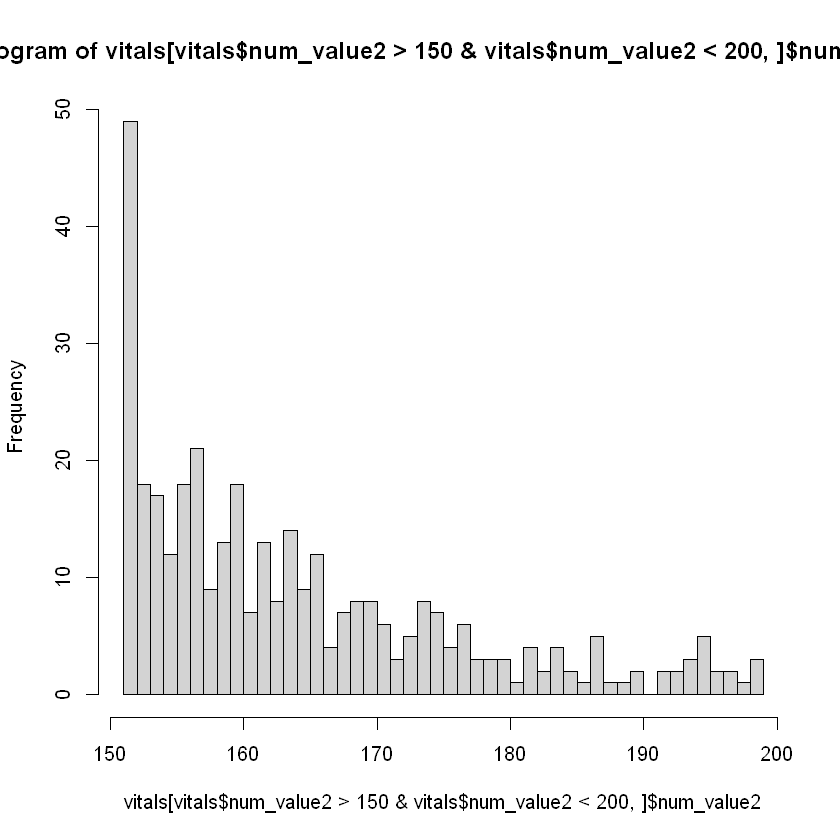

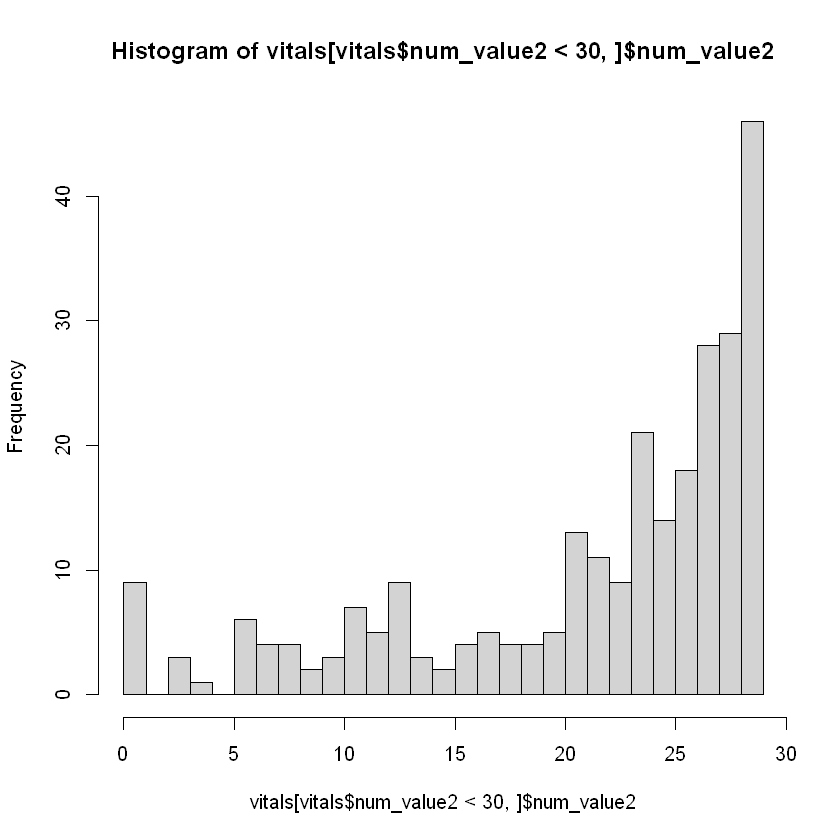

In [57]:
# again, DBP value is num_value2
summary(vitals$num_value2)
nrow(vitals %>% filter(num_value2 > 200))
nrow(vitals %>% filter(num_value2 < 15))

hist(vitals[vitals$num_value2 > 150 & vitals$num_value2 < 200,]$num_value2, breaks =50)
hist(vitals[vitals$num_value2 < 30,]$num_value2, breaks = 30)

### Clean DBP 
- note: rows that are the same except for values: to be taken once --> will do together with other features, take averages!
- consider erroneous values for DBP if SBP > 10*DBP, and if either SBP or DBP = 0
- there's one patient who has duplicated recorded time

[1] 212379

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.0    64.0    75.0    75.8    86.0   238.0 

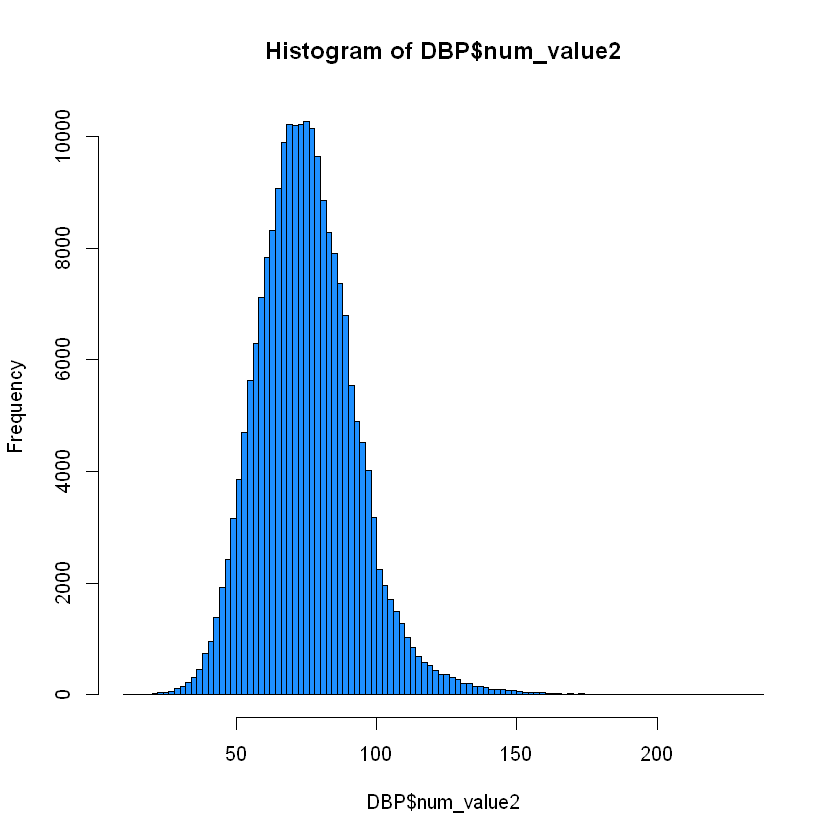

In [68]:
# remove erroneous values for DBP if SBP > 10*DBP, and either SBP or DBP = 0
# will bind rows later --> so ok to filter instead of replacing by NA
DBP <- vitals %>% filter(features == "SBP" & num_value1*num_value2 !=0) %>% 
                    mutate(num_value2 = ifelse(num_value1 > 10*num_value2, NA, num_value2)) %>%
                    drop_na(num_value2) 
nrow(DBP)
summary(DBP$num_value2)
hist(DBP$num_value2, col = "dodgerblue", breaks = 125)

In [59]:
# check DBP and SBP
DBP %>% filter(num_value2 <20) %>% arrange(num_value2)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
JCcc3257,131182220877,19167354,Vitals,SBP,,2016-02-29 17:06:00+00:00,69,10
JCd9dc5f,131251027157,30169334,DATA VALIDATE,SBP,,2018-04-16 00:42:00+00:00,94,12
JCe14e5b,131273610467,39958051,Vitals,SBP,,2019-09-02 05:15:00+00:00,51,13
JCda2fe2,131259025143,32709155,DATA VALIDATE,SBP,,2018-09-27 16:48:00+00:00,35,13
JCe5faab,131272707003,39379259,Vitals,SBP,,2019-07-27 17:30:00+00:00,64,13
JCd5f334,131199507206,21510749,Vitals,SBP,,2016-09-15 08:06:00+00:00,102,13
JCe64650,131115252104,16646852,IIC VS,SBP,,2015-08-14 21:35:00+00:00,116,13
JCe64650,131115252104,16646852,ICU VS,SBP,,2015-08-14 21:30:00+00:00,116,13
JCe5faab,131272707003,39379259,Vitals,SBP,,2019-07-27 17:31:00+00:00,64,13


In [69]:
# change variable name and drop SBP
DBP <- DBP %>% mutate(features = "DBP") %>% select(-c(num_value1)) %>%
                rename(values = num_value2) %>% distinct()

# duplicated row for all columns
nrow(DBP %>% distinct())
DBP[duplicated(DBP), ]

# rows that are the same except for values: to be taken once --> will do together with other features, take average!
DBP %>% group_by_at(vars(-values)) %>% filter(n() > 1) 

[1] 212378

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCdc571d,131265716149,35550390,Vitals,DBP,,2019-03-10 10:00:00+00:00,71
JCdc571d,131265716149,35550390,Vitals,DBP,,2019-03-10 10:00:00+00:00,63


In [67]:
# check BP and other features, note that RR seems to be quite different, maybe take average is better
vitals %>% filter(pat_enc_csn_id_coded == 131265716149, recorded_time == '2019-03-10 10:00:00+00:00') %>%
        arrange(features)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,num_value1,num_value2
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
JCdc571d,131265716149,35550390,Vitals,Pulse,,2019-03-10 10:00:00+00:00,110.0,NA
JCdc571d,131265716149,35550390,Vitals,Pulse,,2019-03-10 10:00:00+00:00,105.0,NA
JCdc571d,131265716149,35550390,Vitals,RR,,2019-03-10 10:00:00+00:00,32.0,NA
JCdc571d,131265716149,35550390,Vitals,RR,,2019-03-10 10:00:00+00:00,26.0,NA
JCdc571d,131265716149,35550390,Vitals,SBP,,2019-03-10 10:00:00+00:00,128.0,71
JCdc571d,131265716149,35550390,Vitals,SBP,,2019-03-10 10:00:00+00:00,121.0,63
JCdc571d,131265716149,35550390,Vitals,Temp,,2019-03-10 10:00:00+00:00,97.7,NA
JCdc571d,131265716149,35550390,Custom Formula Data,Temp,,2019-03-10 10:00:00+00:00,36.4,NA
JCdc571d,131265716149,35550390,Vitals,Temp,,2019-03-10 10:00:00+00:00,97.6,NA


[1] 801954

[1] "Pulse"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   73.00   87.00   88.72  102.00  300.00     590 
[1] "RR"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   16.00   18.00   19.24   21.00  189.00     566 


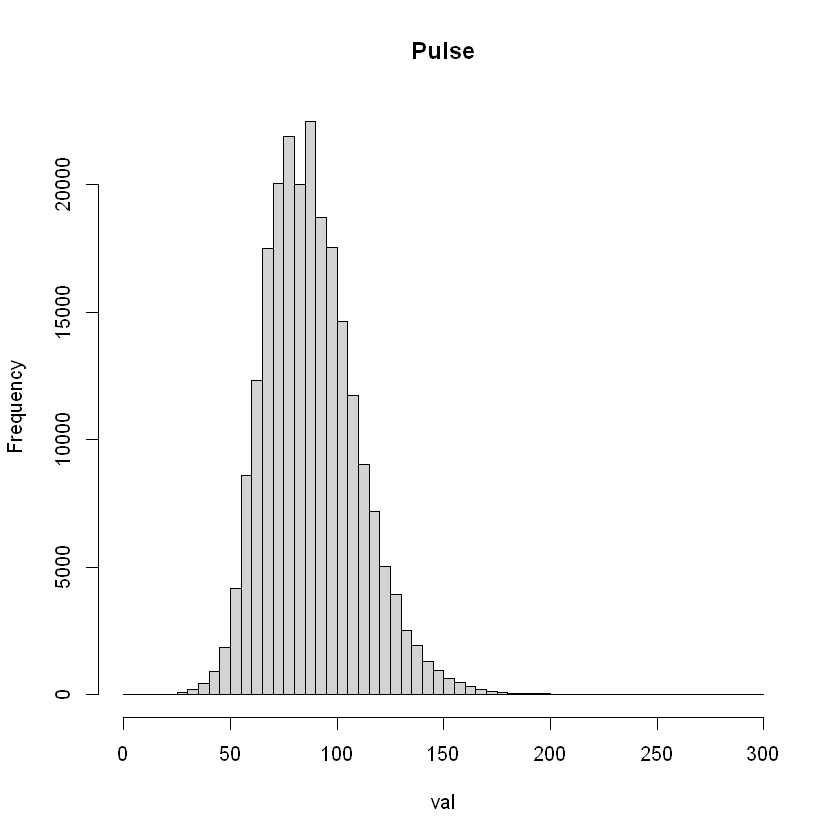

[1] "SBP"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0     111     127     129     145     419     982 


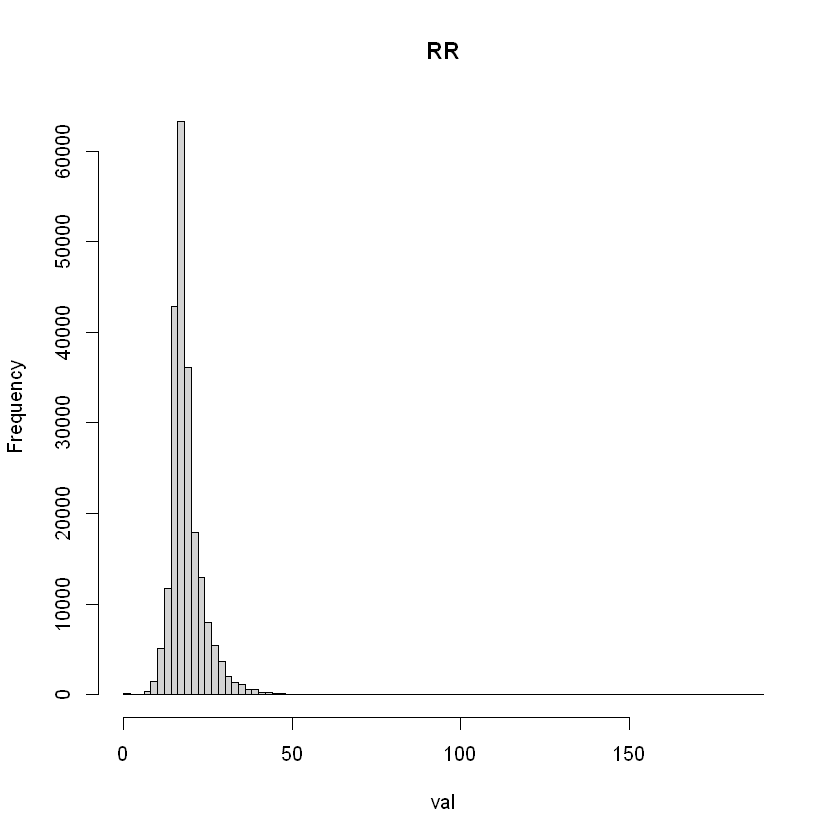

[1] "Temp"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   36.90   97.50   71.66   98.40  110.20     711 


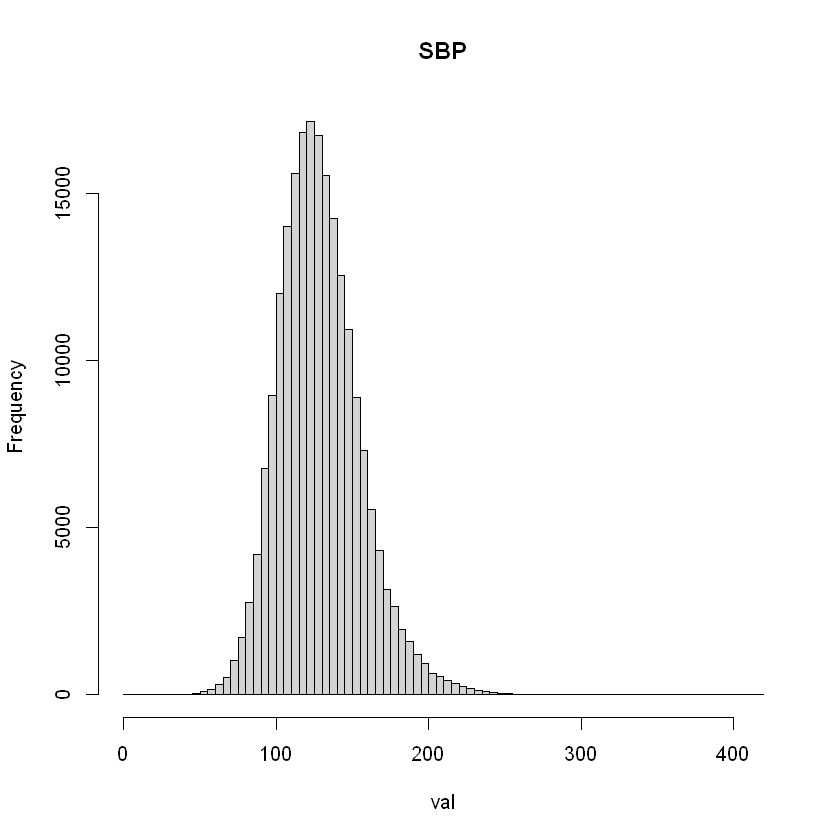

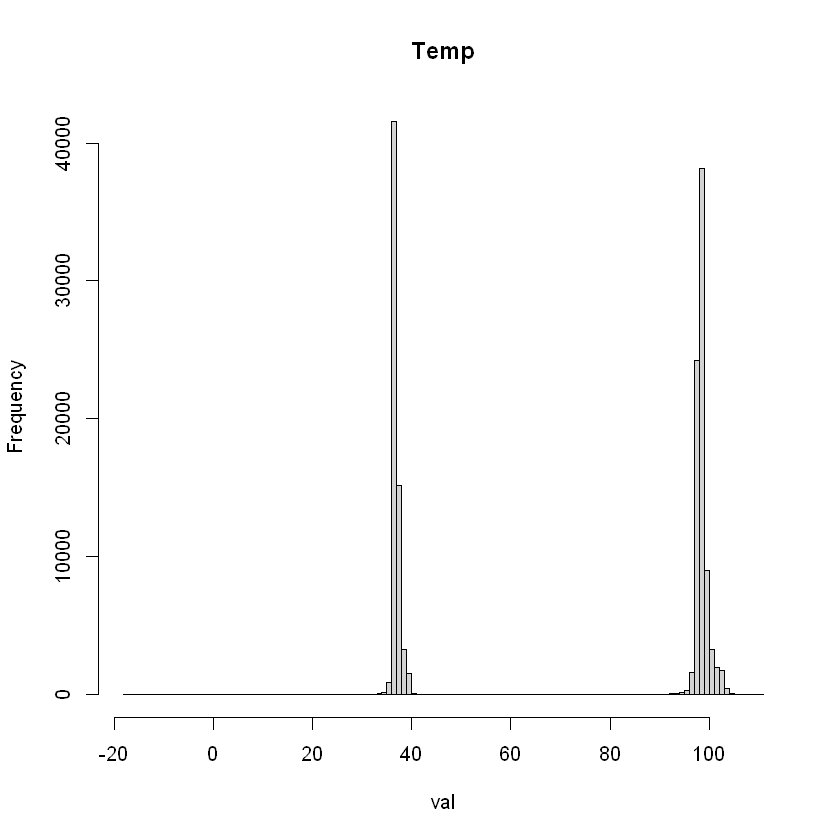

In [108]:
# this set, we look at num_value1 only, no DBP
# keep only variable in the list of VS, all use num_value1
vitals <- vitals %>% filter(features %in% fs_feats) %>%
                        select(-c(num_value2)) %>% rename(values=num_value1) %>% distinct()

# check for distributions of these
nrow(vitals) # 801954
for (f in fs_feats){
    print(f)
    df = vitals %>% select(features, values) %>%  filter(features==f)
    val = df$values
    print(summary(val))
    hist(val, main = f, breaks = 100)
}

### Explore SBP, Pulse, RR

[1] 3

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC2a1a193,131274427714,40485010,Hemodynamic Measurements,SBP,,2019-08-24 20:31:04+00:00,0
JCd40aa4,131178765150,18643252,DATA VALIDATE,SBP,,2016-02-29 20:45:00+00:00,33
JCd40aa4,131178765150,18643252,Vitals,SBP,,2016-02-29 20:46:51+00:00,33
JCda2fe2,131259025143,32709155,DATA VALIDATE,SBP,,2018-09-27 16:48:00+00:00,35
JCe04ae2,131279230382,43521438,Vitals,SBP,,2019-11-01 02:10:00+00:00,37
JCebdb33,131281205434,44717893,Vitals,SBP,,2019-12-04 06:45:00+00:00,41
JCe26657,131275652065,41270371,ICU VS,SBP,,2019-08-22 21:39:00+00:00,41
JCe24bea,131272371893,39164758,Vitals,SBP,,2019-08-06 22:27:00+00:00,44
JCd5e08c,131251219481,30241173,Vitals,SBP,,2018-05-09 20:00:00+00:00,45


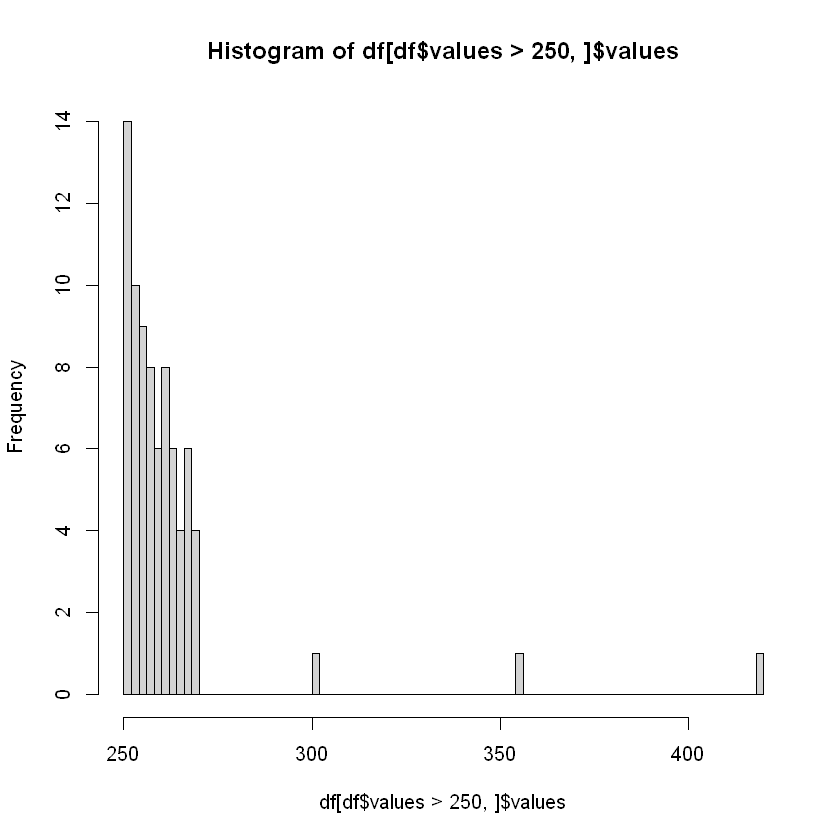

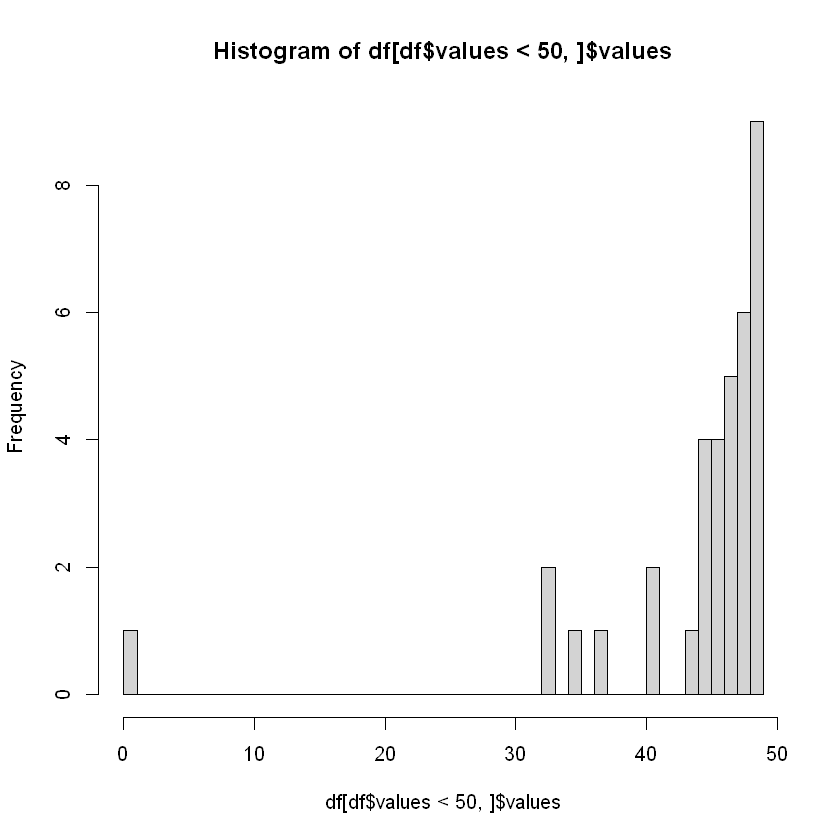

In [71]:
df <- vitals %>% filter(features == "SBP")
nrow(filter(df, values > 310 | values <33))

vitals %>% filter(features == 'SBP' & (values > 300 | values < 50)) %>% arrange(values)

hist(df[df$values > 250,]$values, breaks=100)
hist(df[df$values < 50,]$values, breaks = 50)

[1] 44

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCe72d41,131183649862,19383309,Vitals/Interventions,Pulse,,2016-03-18 06:19:00+00:00,0
JCe72d41,131183649862,19383309,Vitals/Interventions,Pulse,,2016-03-18 06:21:00+00:00,0
JCcb8151,131185153421,19616256,ICU VS,Pulse,,2016-04-21 07:46:00+00:00,0
JCe72d41,131183649862,19383309,Vitals/Interventions,Pulse,,2016-03-18 06:23:00+00:00,0
JCe72d41,131183649862,19383309,Vitals/Interventions,Pulse,,2016-03-18 06:25:00+00:00,0
JCe72d41,131183649862,19383309,Vitals/Interventions,Pulse,,2016-03-18 06:27:00+00:00,0
JCe72d41,131183649862,19383309,Vitals/Interventions,Pulse,,2016-03-18 06:16:00+00:00,0
JCe72d41,131183649862,19383309,Vitals/Interventions,Pulse,,2016-03-18 06:29:00+00:00,0
JCd8be4c,131275284311,41032910,M/S VS,Pulse,,2019-08-17 08:01:00+00:00,3


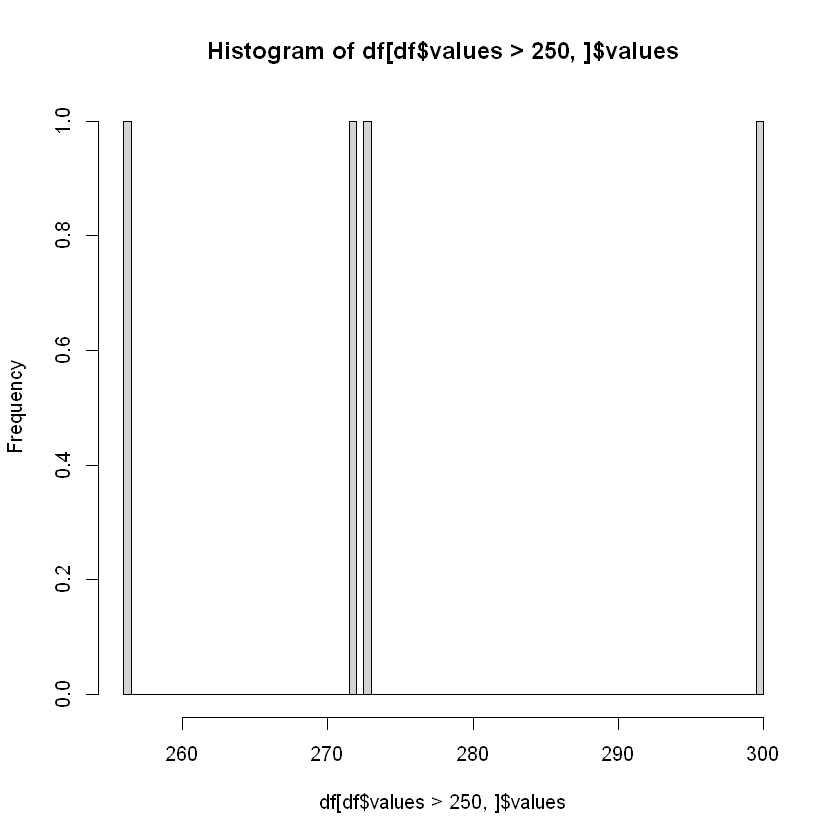

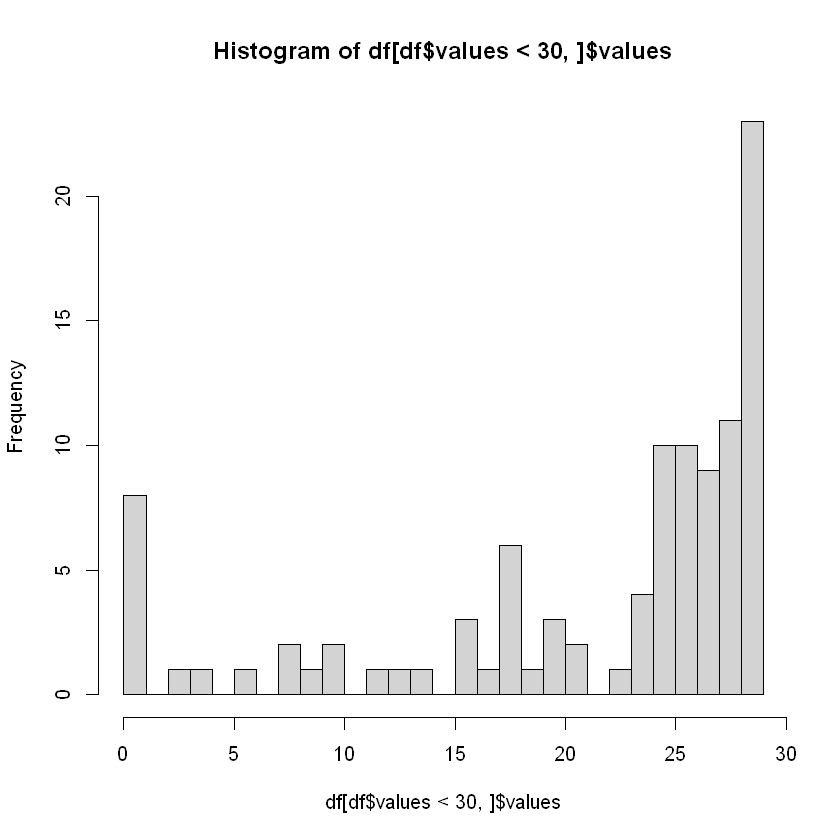

In [73]:
df <- vitals %>% filter(features == "Pulse")
nrow(filter(df, values > 250 | values < 25)) # remove <10 only
filter(df, values > 250 | values < 25) %>% arrange(values)

hist(df[df$values > 250,]$values, breaks=100)
hist(df[df$values < 30,]$values, breaks=25)

[1] 247

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCe417b1,131230525726,24701848,Vitals,RR,,2017-05-29 02:30:00+00:00,1
JCe63c45,131274983183,40839473,ICU VS,RR,,2019-09-26 05:35:00+00:00,1
JCd6e0ff,131259219370,32779469,Vitals,RR,,2018-10-28 19:00:00+00:00,1
JCd70f22,131100576218,16135288,RT Assess/ Treatment,RR,,2015-08-04 11:48:00+00:00,1
JCdaaa7f,131123254891,16887606,Vitals,RR,,2015-09-14 03:15:00+00:00,2
JCd01751,131275616770,41245015,Mod Sedation,RR,,2019-08-22 00:13:00+00:00,2
JCd58afe,131258964263,32686475,RT Assess/ Treatment,RR,,2018-10-18 14:57:00+00:00,2
JCdc673b,131259855944,33008510,Vitals,RR,,2018-10-26 02:33:00+00:00,2
JCe82ff5,131239118324,26341902,Hemodynamic Measurements,RR,,2017-09-21 23:55:44+00:00,2


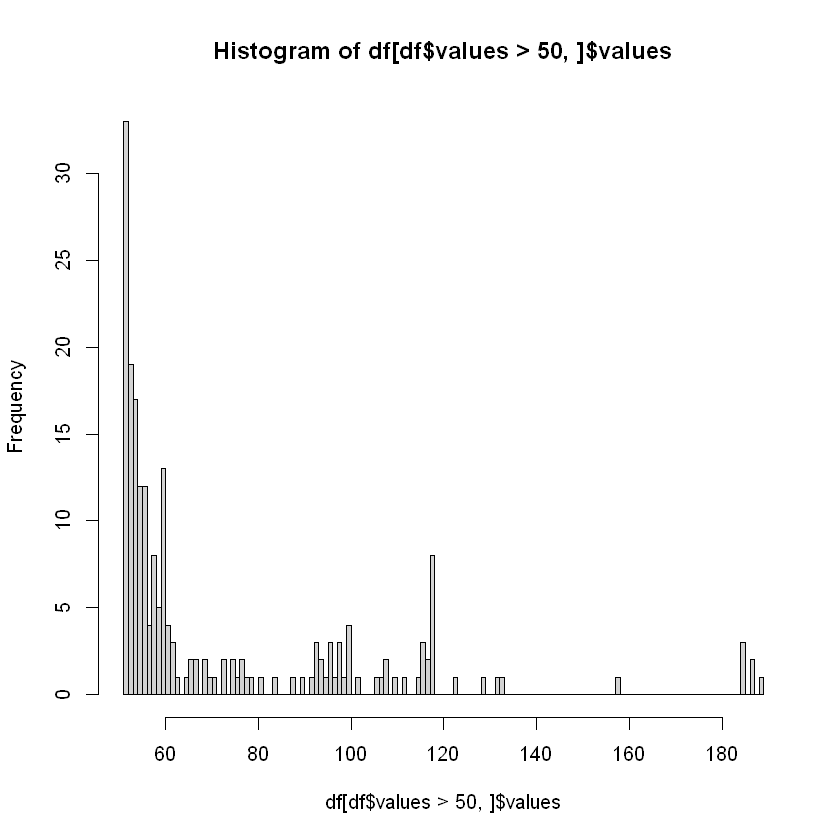

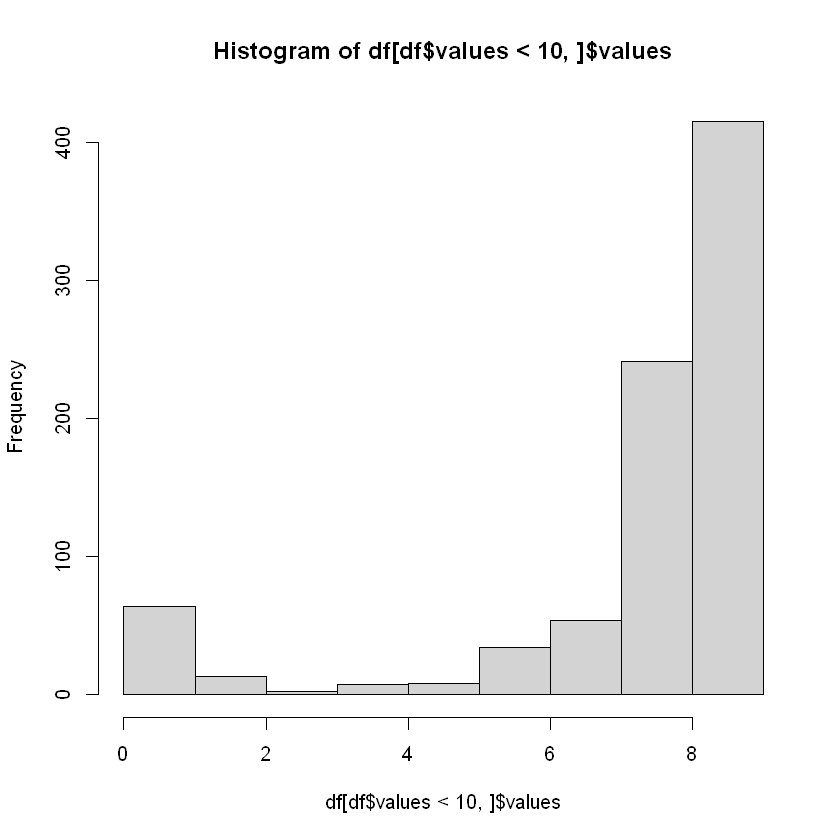

In [77]:
df <- vitals %>% filter(features == "RR")
nrow(filter(df, values > 70 | values < 8))

# there are some 0
filter(df, values > 70 | values < 8 & values > 0) %>% arrange(values)

hist(df[df$values > 50,]$values, breaks=100)
hist(df[df$values < 10,]$values, breaks=10)

In [109]:
unique(vitals$features)
summary(vitals$values)

head(vitals)

[1] "RR"    "SBP"   "Temp"  "Pulse"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   26.00   87.00   77.63  109.00  419.00    2849 

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JCe15c20,131254814765,31338316,Vitals,RR,,2018-08-22 16:00:00+00:00,16
2,JCd0a8db,131264538689,34735715,DATA VALIDATE,SBP,,2019-02-11 11:45:00+00:00,178
3,JCdeb93e,131266509496,36078047,M/S VS,Temp,,2019-04-03 22:45:00+00:00,98
4,JCcbf217,131241202790,27087604,DATA VALIDATE,SBP,,2017-12-18 06:30:00+00:00,88
5,JCd64572,131231133056,24776616,Vitals,SBP,,2017-06-21 20:45:00+00:00,163
6,JCd884d0,131121019062,16807919,DATA VALIDATE,SBP,,2015-10-16 19:00:00+00:00,97


### Clean the variables: Temp, SBP, Pulse, and RR

In [113]:
# nothing btwn 45-47, so if > 45 (or actually num_value1 >= 75), convert to C
# replace num_value1 < 20 --> only 2: 0.1 and 9.4 for Temp, and a bunch for Temp(in C)
vitals <- vitals %>% 
            mutate(values=ifelse(features=="Temp",                                  
                                 ifelse(values < 26, NA,
                                         ifelse(values <= 45, values, round((values - 32)*5.0/9.0))), values))

summary(vitals %>% filter(features == "Temp") %>% select(values))

     values     
 Min.   :26.00  
 1st Qu.:36.70  
 Median :37.00  
 Mean   :36.99  
 3rd Qu.:37.00  
 Max.   :43.40  
 NA's   :743    

In [119]:
# remove  all NA's, by each feature, as the data is in the long format,
# keep only distinct rows, ok with recorded_time same but different values
vitals <- vitals %>% 
            mutate(values = ifelse(features == "SBP" & values < 30, NA, # < 33 or 30 same effect & > 310 old
                             ifelse(features == "Pulse" & values < 11, NA, # 21 before
                                 ifelse(features == "RR" & (values < 5 | values > 60), NA, # 60 before (tried 70)
                                         ifelse(features == "Temp" & values < 26, NA, values))))) %>%  # 29 before, 26 min here
            drop_na(values) %>% distinct()

nrow(vitals)
vitals %>% count(features) %>% arrange(-n)
nrow(vitals %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct())

[1] 798882

features,n
<chr>,<int>
Pulse,226963
RR,215294
SBP,212421
Temp,144204


[1] 45613

[1] "Pulse"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.00   73.00   87.00   88.72  102.00  300.00 
[1] "RR"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   16.00   18.00   19.22   21.00   60.00 


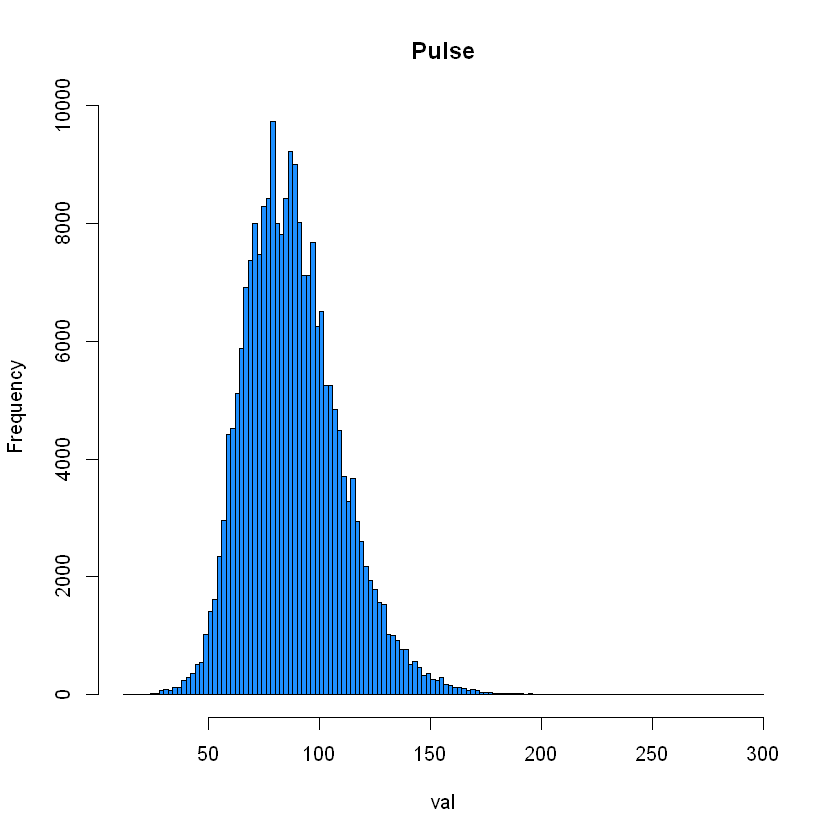

[1] "SBP"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     33     111     127     129     145     419 


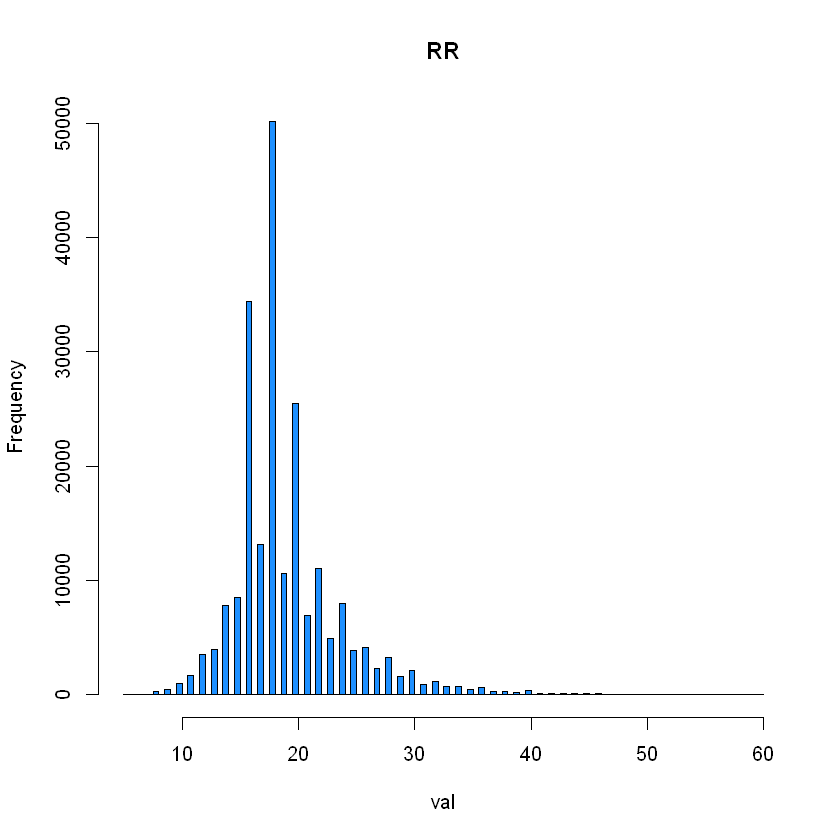

[1] "Temp"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26.00   36.70   37.00   36.99   37.00   43.40 


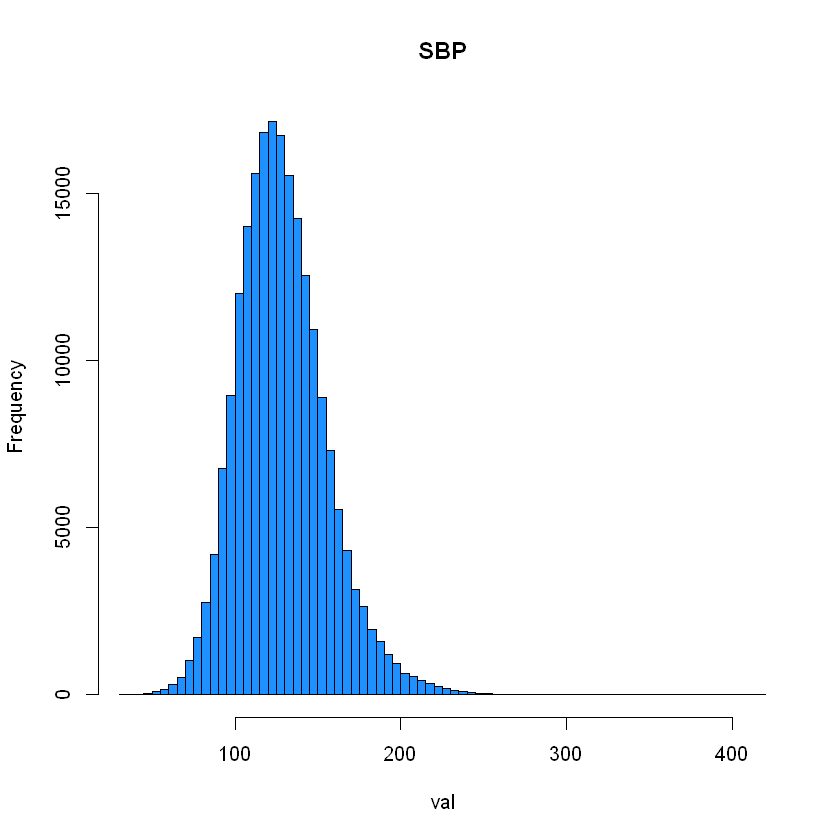

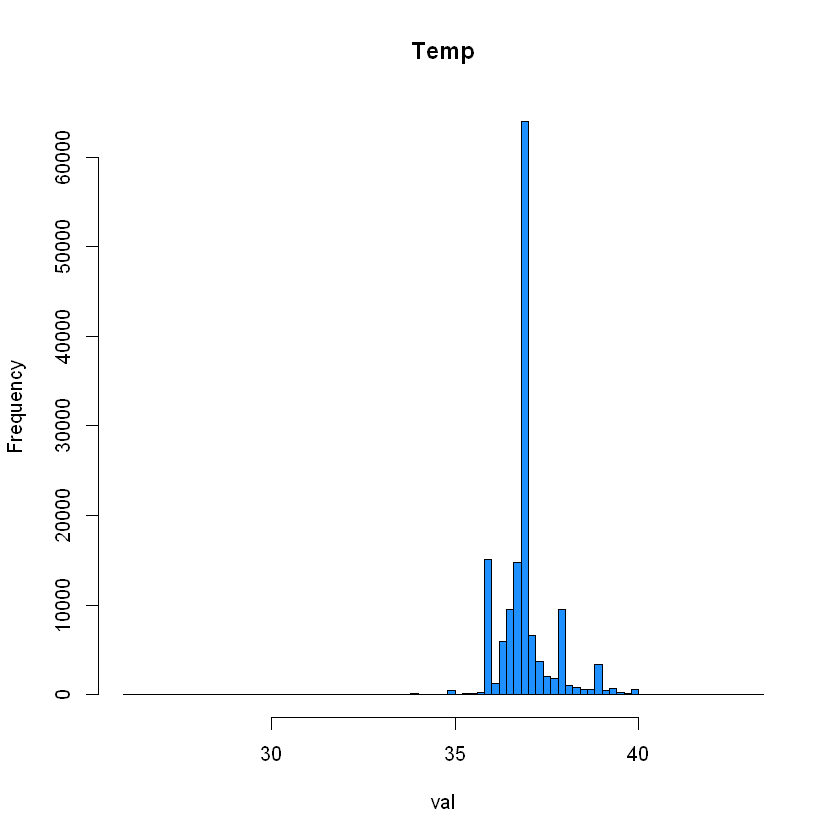

In [120]:
for (f in fs_feats){
    print(f)
    df = vitals %>% select(features, values) %>%  filter(features==f)
    val = df$values
    print(summary(val))
    hist(val, main = f, col="dodgerblue", xlim=c(min(val), max(val)), breaks= 120)
}

In [124]:
# look at duplicates rows with same recorded time, but different values. 
for (f in fs_feats){
    print(f)
    df <- vitals %>% filter(features == f) %>% group_by_at(vars(-values)) %>% filter(n() > 1)
    print(nrow(df))
}

[1] "Pulse"
[1] 8
[1] "RR"
[1] 4
[1] "SBP"
[1] 4
[1] "Temp"
[1] 38


In [126]:
# check for duplicates all but values
DBP %>% group_by_at(vars(-values)) %>% filter(n() > 1) 
vitals %>% filter(features == "SBP") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)
vitals %>% filter(features == "RR") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)
vitals %>% filter(features == "Pulse") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)
vitals %>% filter(features == "Temp") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCdc571d,131265716149,35550390,Vitals,DBP,,2019-03-10 10:00:00+00:00,71
JCdc571d,131265716149,35550390,Vitals,DBP,,2019-03-10 10:00:00+00:00,63


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCe62a6e,131180583645,18920151,IIC VS,SBP,,2016-02-20 11:00:00+00:00,117
JCe62a6e,131180583645,18920151,IIC VS,SBP,,2016-02-20 11:00:00+00:00,100
JCdc571d,131265716149,35550390,Vitals,SBP,,2019-03-10 10:00:00+00:00,128
JCdc571d,131265716149,35550390,Vitals,SBP,,2019-03-10 10:00:00+00:00,121


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCdc571d,131265716149,35550390,Vitals,RR,,2019-03-10 10:00:00+00:00,32
JCdc571d,131265716149,35550390,Vitals,RR,,2019-03-10 10:00:00+00:00,26
JC2a22f76,131286819362,47396208,ICU VS,RR,,2020-03-08 10:00:00+00:00,29
JC2a22f76,131286819362,47396208,ICU VS,RR,,2020-03-08 10:00:00+00:00,27


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCe768a6,131073241118,14411297,ICU VS,Pulse,,2015-03-08 10:00:00+00:00,76
JCe768a6,131073241118,14411297,ICU VS,Pulse,,2015-03-08 10:00:00+00:00,75
JCe62a6e,131180583645,18920151,IIC VS,Pulse,,2016-02-20 11:00:00+00:00,75
JCe62a6e,131180583645,18920151,IIC VS,Pulse,,2016-02-20 11:00:00+00:00,79
JCdc571d,131265716149,35550390,Vitals,Pulse,,2019-03-10 10:00:00+00:00,110
JCdc571d,131265716149,35550390,Vitals,Pulse,,2019-03-10 10:00:00+00:00,105
JC2a22f76,131286819362,47396208,ICU VS,Pulse,,2020-03-08 10:00:00+00:00,130
JC2a22f76,131286819362,47396208,ICU VS,Pulse,,2020-03-08 10:00:00+00:00,125


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
JCd53348,131262009998,33772084,Custom Formula Data,Temp,,2019-01-21 11:30:00+00:00,36.9
JCd53348,131262009998,33772084,Custom Formula Data,Temp,,2019-01-21 11:30:00+00:00,37.0
JCdbb906,131262467454,33923954,Custom Formula Data,Temp,,2019-02-11 05:09:00+00:00,37.0
JCdbb906,131262467454,33923954,Custom Formula Data,Temp,,2019-02-11 05:09:00+00:00,36.6
JCe6d54b,131262755657,34024408,Custom Formula Data,Temp,,2019-02-06 04:22:00+00:00,37.5
JCe6d54b,131262755657,34024408,Custom Formula Data,Temp,,2019-02-06 04:22:00+00:00,38.0
JC2a12ea7,131263055091,34131380,Custom Formula Data,Temp,,2019-01-03 04:15:00+00:00,36.7
JC2a12ea7,131263055091,34131380,Custom Formula Data,Temp,,2019-01-03 04:15:00+00:00,37.0
JCd9a764,131267455088,36699857,Custom Formula Data,Temp,,2019-04-05 02:53:00+00:00,37.0


### Combined DBP back to VS!

In [128]:
head(DBP, n=1)
head(vitals, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JCd0a8db,131264538689,34735715,DATA VALIDATE,DBP,,2019-02-11 11:45:00+00:00,104


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,JCe15c20,131254814765,31338316,Vitals,RR,,2018-08-22 16:00:00+00:00,16


In [130]:
nrow(DBP)
nrow(vitals)
nrow(cohort) #

vitals <- bind_rows(vitals, DBP) %>% mutate(feature_type = "vitals") 
summary(vitals$values)
nrow(vitals) 
nrow(vitals %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #43,143

[1] 212378

[1] 798882

[1] 45796

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0    36.7    72.0    72.3   102.0   419.0 

[1] 1011260

[1] 45613

In [133]:
# list the duplicated rows (except values) again
dup <- vitals %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% arrange(pat_enc_csn_id_coded, features)

In [137]:
nrow(dup)
dup_avg <- dup %>% group_by_at(vars(-values)) %>% summarise(values = mean(values))
nrow(dup_avg)

[1] 56

`summarise()` regrouping output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'template', 'features', 'units', 'recorded_time' (override with `.groups` argument)



[1] 28

In [139]:
# for those duplicated rows, take averages of values
cohort_vitals <- vitals %>% group_by_at(vars(-values)) %>% summarise(values = mean(values))
nrow(vitals)
nrow(cohort_vitals)

`summarise()` regrouping output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'template', 'features', 'units', 'recorded_time' (override with `.groups` argument)



[1] 1011260

[1] 1011232

In [140]:
head(cohort_vitals, n=1)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,feature_type,values
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
JC29f8ad2,131274729058,40679773,Custom Formula Data,Temp,,2019-08-31 10:14:00+00:00,vitals,36.9


In [141]:
summary(cohort_vitals$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0    36.7    72.0    72.3   102.0   419.0 

In [142]:
# save cohort vital signs after cleaning, no NA's here, has recorded time, used for binning
# cohort_vitals
write.csv(vitals, file.path(featuredir, "2_3_coh2_vitals.csv"), row.names=FALSE)

## Get the first set of vital signs - UPDATE COHORT
This will result in an updated (smaller) cohort, only with observations whose have at least a complet set of vital signs.

These blocks of code in this section are the same in:
- `1_cohort/1.5_cohort_complete1vitals_R.ipynb`
- second part of the `2.3_vitalsigns_R.ipynb`

In [114]:
# read inputs
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"

cohort_vitals <- read.csv(file.path(featuredir, "2_3_coh2_vitals.csv"))
nrow(cohort_vitals)
length(unique(cohort_vitals$pat_enc_csn_id_coded))

[1] 1011260

[1] 45613

In [29]:
head(vitals)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,template,features,units,recorded_time,values,feature_type
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,JCe15c20,131254814765,31338316,Vitals,RR,,2018-08-22 16:00:00+00:00,16,vitals
2,JCd0a8db,131264538689,34735715,DATA VALIDATE,SBP,,2019-02-11 11:45:00+00:00,178,vitals
3,JCdeb93e,131266509496,36078047,M/S VS,Temp,,2019-04-03 22:45:00+00:00,37,vitals
4,JCcbf217,131241202790,27087604,DATA VALIDATE,SBP,,2017-12-18 06:30:00+00:00,88,vitals
5,JCd64572,131231133056,24776616,Vitals,SBP,,2017-06-21 20:45:00+00:00,163,vitals
6,JCd884d0,131121019062,16807919,DATA VALIDATE,SBP,,2015-10-16 19:00:00+00:00,97,vitals


In [82]:
# same as above, but takes ~8min to run
vs1st <- cohort_vitals %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                                  recorded_time, features, values, feature_type) %>% 
            mutate(recorded_time = ymd_hms(recorded_time)) %>% 
            group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, features) %>%
            top_n(n=-1, recorded_time) %>% # slice_min(n=1, recorded_time, with_ties = FALSE) 
            summarise(first_val = mean(values, na.rm=TRUE)) %>% distinct()

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'. You can override using the `.groups` argument.



In [48]:
# only have 1 unique time because we already took care of this 
nrow(vs1st) #226510
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded, features))
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded)) #45613
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded)) 

[1] 226510

[1] 226510

[1] 45613

[1] 45613

In [92]:
write.csv(vs1st, file.path(featuredir, "2_3_coh2_vs1st.csv"), row.names=FALSE)

In [115]:
# note: cohort size dropped further
# get the the cohort with 1st complete set of VS for ESI imputation
cohort1vs <- vs1st %>% drop_na() %>% spread(features, first_val) %>% drop_na() 
colnames(cohort1vs)
nrow(cohort1vs %>% distinct(pat_enc_csn_id_coded))

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "DBP"                    
[5] "Pulse"                   "RR"                     
[7] "SBP"                     "Temp"

[1] 44258

In [116]:
# 44258
write.csv(cohort1vs, file.path(cohortdir, "1_3_cohort.csv"), row.names=FALSE)

## Get other VS related features for simple data/model: 

- Demographic features
- Vital signs: first and last values, summary statistics, difference from last - first and max - min
- Updated cohort only contains those with at least a complete set of vital signs

Note that first and last values at the same time might have more than 1. However, this was taken care of during the processing of vital signs, when we took the averages if there are multiple values at the same recorded_time

In [76]:
# read inputs
featuredir = "../../OutputTD/2_features"

cohort1vs <- read.csv(file.path(featuredir, "coh3_vs1st_complete.csv"))
cohort_vitals <- read.csv(file.path(featuredir, "cohort_vitals.csv"))

In [58]:
nrow(cohort1vs)
nrow(cohort1vs %>% drop_na() %>% distinct())
nrow(cohort1vs %>% distinct(pat_enc_csn_id_coded)) #44258

[1] 44258

[1] 44258

In [60]:
head(cohort1vs, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,DBP,Pulse,RR,SBP,Temp
,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,JC29f8ad2,131274729058,40679773,74,95,20,118,36.95


In [83]:
# get the most recent value of each feature, top_n(n=1, recorded_time) or slice_max
vs_last <- cohort_vitals %>% select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                                  recorded_time, features, values, feature_type) %>% 
            group_by(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, features) %>%
            top_n(n=1, recorded_time) %>%
            summarise(last_val = mean(values, na.rm=TRUE)) %>% distinct() # %>% 
#             drop_na() %>% spread(features, last_val) %>% drop_na() 

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'. You can override using the `.groups` argument.



In [93]:
# only have 1 unique time because we already took care of this 
nrow(cohort1vs)
nrow(vs_last)
nrow(vs_last %>% distinct(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded))
nrow(vs_last %>% distinct(pat_enc_csn_id_coded)) # 44258

[1] 44258

[1] 226510

[1] 45613

[1] 45613

In [74]:
# check cohortID not in vitals as cohortIDs were derived before getting vitals
# nrow(cohort %>% filter(!anon_id %in% vs1st$anon_id))

In [96]:
colnames(cohort1vs); colnames(vs1st); colnames(vs_last); colnames(cohort_vitals)
nrow(vs1st %>% distinct(pat_enc_csn_id_coded)); nrow(vs_last %>% distinct(pat_enc_csn_id_coded))
nrow(cohort1vs)
nrow(cohort_vitals)

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "features"               
[5] "first_val"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "features"               
[5] "last_val"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
[3] "inpatient_data_id_coded" "template"               
[5] "features"                "units"                  
[7] "recorded_time"           "values"                 
[9] "feature_type"

[1] 45613

[1] 45613

[1] 44258

[1] 1011260

In [102]:
# join the updated cohort (with a complete set of VS), first, last, and the rest of values for vitals
coh3_vitals <- left_join(cohort1vs, vs1st) %>% left_join(vs_last) %>% left_join(cohort_vitals) %>%
                select(anon_id, pat_enc_csn_id_coded, inpatient_data_id_coded, 
                       features, first_val, last_val, values, feature_type)
nrow(coh3_vitals)
coh3_vitals %>% group_by(features) %>% count()

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "features")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "features")



[1] 987260

features,n
<chr>,<int>
DBP,206624
Pulse,221005
RR,209402
SBP,206661
Temp,143568


In [103]:
head(coh3_vitals, n=1)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,features,first_val,last_val,values,feature_type
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
JC29f8ad2,131274729058,40679773,DBP,74,62,74,vitals


In [104]:
# get summary stats, including differences for first and last (0 if 1 value), min and max
# all the NA were actually already dropped, so na.rm here is redundant
vsum <- coh3_vitals %>% 
            group_by(anon_id, pat_enc_csn_id_coded, features, first_val, last_val) %>%
            summarise(count = n(), meanx = mean(values, na.rm=TRUE), medianx = median(values, na.rm=TRUE), 
                      minx = min(values, na.rm=TRUE), maxx = max(values, na.rm=TRUE), sdx = sd(values, na.rm=TRUE),
                      madx = mad(values, na.rm=TRUE), IQRx = IQR(values, na.rm=TRUE)) %>%
            mutate(mmdiff = round(maxx - minx, 1), fldiff = round(last_val - first_val, 1)) #

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'features', 'first_val'. You can override using the `.groups` argument.



In [106]:
head(vsum, n=1)

anon_id,pat_enc_csn_id_coded,features,first_val,last_val,count,meanx,medianx,minx,maxx,sdx,madx,IQRx,mmdiff,fldiff
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JC29f8ad2,131274729058,DBP,74,62,2,68,68,62,74,8.485281,8.8956,6,12,-12


In [107]:
nrow(vsum)
colnames(vsum)
summary(vsum)
table(vsum$features)

[1] 221290

[1] "anon_id"              "pat_enc_csn_id_coded" "features"            
 [4] "first_val"            "last_val"             "count"               
 [7] "meanx"                "medianx"              "minx"                
[10] "maxx"                 "sdx"                  "madx"                
[13] "IQRx"                 "mmdiff"               "fldiff"

   anon_id          pat_enc_csn_id_coded   features           first_val     
 Length:221290      Min.   :1.311e+11    Length:221290      Min.   :  6.00  
 Class :character   1st Qu.:1.312e+11    Class :character   1st Qu.: 36.80  
 Mode  :character   Median :1.312e+11    Mode  :character   Median : 71.00  
                    Mean   :1.312e+11                       Mean   : 71.97  
                    3rd Qu.:1.313e+11                       3rd Qu.:103.00  
                    Max.   :1.313e+11                       Max.   :419.00  
                                                                            
    last_val          count             meanx           medianx      
 Min.   :  5.00   Min.   :  1.000   Min.   :  8.00   Min.   :  8.00  
 1st Qu.: 36.80   1st Qu.:  2.000   1st Qu.: 36.75   1st Qu.: 36.80  
 Median : 68.00   Median :  3.000   Median : 70.20   Median : 70.00  
 Mean   : 69.02   Mean   :  4.461   Mean   : 70.15   Mean   : 69.93  
 3rd Qu.: 98.00   3rd Qu.:  5.000 


  DBP Pulse    RR   SBP  Temp 
44258 44258 44258 44258 44258 

In [108]:
# replace na of sdx (due to denominator of n-1) as 0
# wide to long on multiple cols to wide
# remove rows with any na --> only complete cases of 1 set of vital signs
vsum_wide <- vsum %>% mutate(sdx = ifelse(is.na(sdx), 0, sdx)) %>%
                gather(variable, value, first_val:fldiff) %>%
                unite(temp, features, variable) %>%
                spread(temp, value) %>% drop_na()

In [111]:
nrow(vsum_wide)
nrow(vsum_wide %>% select(pat_enc_csn_id_coded) %>% distinct()) 
colnames(vsum_wide)
summary(vsum_wide)

[1] 44258

Adding missing grouping variables: `anon_id`



[1] 44258

[1] "anon_id"              "pat_enc_csn_id_coded" "DBP_count"           
 [4] "DBP_first_val"        "DBP_fldiff"           "DBP_IQRx"            
 [7] "DBP_last_val"         "DBP_madx"             "DBP_maxx"            
[10] "DBP_meanx"            "DBP_medianx"          "DBP_minx"            
[13] "DBP_mmdiff"           "DBP_sdx"              "Pulse_count"         
[16] "Pulse_first_val"      "Pulse_fldiff"         "Pulse_IQRx"          
[19] "Pulse_last_val"       "Pulse_madx"           "Pulse_maxx"          
[22] "Pulse_meanx"          "Pulse_medianx"        "Pulse_minx"          
[25] "Pulse_mmdiff"         "Pulse_sdx"            "RR_count"            
[28] "RR_first_val"         "RR_fldiff"            "RR_IQRx"             
[31] "RR_last_val"          "RR_madx"              "RR_maxx"             
[34] "RR_meanx"             "RR_medianx"           "RR_minx"             
[37] "RR_mmdiff"            "RR_sdx"               "SBP_count"           
[40] "SBP_first_val"        "SBP_fldiff"           "SBP_IQRx"            
[43] "SBP_last_val"         "SBP_madx"             "SBP_maxx"            
[46] "SBP_meanx"            "SBP_medianx"          "SBP_minx"            
[49] "SBP_mmdiff"           "SBP_sdx"              "Temp_count"          
[52] "Temp_first_val"       "Temp_fldiff"          "Temp_IQRx"           
[55] "Temp_last_val"        "Temp_madx"            "Temp_maxx"           
[58] "Temp_meanx"           "Temp_medianx"         "Temp_minx"           
[61] "Temp_mmdiff"          "Temp_sdx"

   anon_id          pat_enc_csn_id_coded   DBP_count      DBP_first_val   
 Length:44258       Min.   :1.311e+11    Min.   : 1.000   Min.   : 13.00  
 Class :character   1st Qu.:1.312e+11    1st Qu.: 2.000   1st Qu.: 67.00  
 Mode  :character   Median :1.312e+11    Median : 3.000   Median : 78.00  
                    Mean   :1.312e+11    Mean   : 4.669   Mean   : 78.59  
                    3rd Qu.:1.313e+11    3rd Qu.: 6.000   3rd Qu.: 89.00  
                    Max.   :1.313e+11    Max.   :58.000   Max.   :219.00  
   DBP_fldiff          DBP_IQRx        DBP_last_val       DBP_madx     
 Min.   :-146.000   Min.   :  0.000   Min.   : 16.00   Min.   : 0.000  
 1st Qu.: -11.000   1st Qu.:  2.000   1st Qu.: 65.00   1st Qu.: 1.483  
 Median :   0.000   Median :  5.500   Median : 74.00   Median : 4.448  
 Mean   :  -3.516   Mean   :  6.879   Mean   : 75.08   Mean   : 5.935  
 3rd Qu.:   3.000   3rd Qu.: 10.000   3rd Qu.: 85.00   3rd Qu.: 8.896  
 Max.   : 138.000   Max.   :115.750   Max. 

In [112]:
# 44258
write.csv(vsum_wide, file.path(featuredir, "coh3_vitals_stats.csv"), row.names=FALSE)